# Задача классификации рукописных арабских цифр
## _Использование глубокого автоэнкодера для снижения размерности данных_

In [120]:
import numpy
import time
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets # load_digits()
import sklearn.cluster # KMeans
import sklearn.metrics

import math

%matplotlib inline

## 1. Загрузка данных

In [121]:
digits = sklearn.datasets.load_digits()

In [122]:
digits['data']

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [123]:
len(digits['data']), len(digits['data'][0])

(1797, 64)

Посмотрим минимальные и максимальные значение пикселей:

In [124]:
min([min(v) for v in digits['data']]), max([max(v) for v in digits['data']])

(0.0, 16.0)

А также метки и их количество:

In [125]:
digits['target'], sorted(set(digits['target']))

(array([0, 1, 2, ..., 8, 9, 8]), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [126]:
len(digits['target'])

1797

__Итак, в размеченном наборе данных всего 1797 цифр, каждая представлена одномерным массивом из 64 элементов (8x8 пикселей)__.

Так они выглядят (первые 50 изображений).

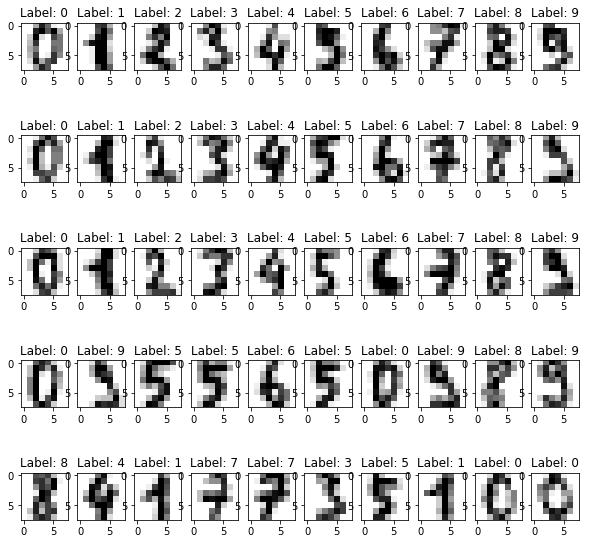

In [127]:
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Label: {digits["target"][i]}')

## 2. Используемые методы (немного матана)

### Автоэнкодеры:

Автоэнкодеры — это нейронные сети прямого распространения, которые восстанавливают входной сигнал на выходе. Внутри у них имеется скрытый слой, который представляет собой код, описывающий модель. Автоэнкодеры конструируются таким образом, чтобы не иметь возможность точно скопировать вход на выходе.

Автоэнкодеры состоят из двух частей: энкодера $g$ и декодера $f$. Энкодер переводит входной сигнал в его представление (код): $h=g(x)$, а декодер восстанавливает сигнал по его коду: $x=f(h)$.

Автоэнкодер, изменяя $f$ и $g$, стремится выучить тождественную функцию $x=f(g(x))$, минимизируя какой-то функционал ошибки: $L(x, f(g(x))$.

In [128]:
%%html
<img src="http://localhost:8888/files/Projects/ml/examples/autoencoder.png"/>

## 3. Подготовим входной набор данных - тренировочных и тестовых

In [175]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(digits['data'], digits['target'], train_size=0.8)

c:\users\stas\envs\data_science\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [176]:
x_train = x_train.astype('float32') / 16.0
x_test = x_test.astype('float32') / 16.0

(array([148., 152., 129., 143., 148., 142., 149., 144., 139., 143.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

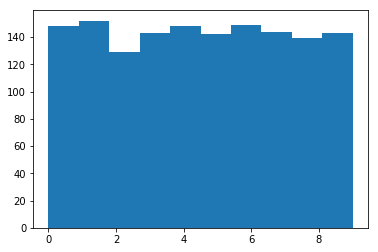

In [177]:
plt.hist(y_train)

(array([30., 30., 48., 40., 33., 40., 32., 35., 35., 37.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

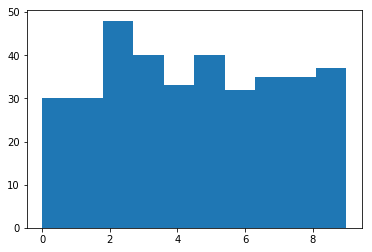

In [178]:
plt.hist(y_test)

In [179]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## 4. Уменьшим размерность с помощью автоэнкодера

В этом случае будем использовать также нейронную сеть прямого распространения, только с большим количеством слоёв.

In [180]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers

In [212]:
encoding_dim = 8 # размерность кодирующего слоя
image_side_size = 8 # размер стороны квадратной картинки в пикселях 
shape_0 = image_side_size * image_side_size

input_image = Input(shape=(shape_0,))

encoded = Dense(32, activation='relu')(input_image)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(shape_0, activation='sigmoid')(decoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [213]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 64)                0         
_________________________________________________________________
dense_204 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_205 (Dense)            (None, 8)                 264       
_________________________________________________________________
dense_206 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_207 (Dense)            (None, 64)                2112      
Total params: 4,744
Trainable params: 4,744
Non-trainable params: 0
_________________________________________________________________


In [214]:
%%time
history = autoencoder.fit(x_train, x_train, epochs=40, batch_size=128, validation_data=(x_test, x_test))

Train on 1437 samples, validate on 360 samples
Epoch 1/40
1437/1437 [==============================] - 6s 4ms/step - loss: 0.6938 - acc: 0.3202 - val_loss: 0.6848 - val_acc: 0.3673
Epoch 2/40
1437/1437 [==============================] - 0s 130us/step - loss: 0.6771 - acc: 0.3949 - val_loss: 0.6628 - val_acc: 0.4220
Epoch 3/40
1437/1437 [==============================] - 0s 152us/step - loss: 0.6327 - acc: 0.4429 - val_loss: 0.5715 - val_acc: 0.4967
Epoch 4/40
1437/1437 [==============================] - 0s 196us/step - loss: 0.5135 - acc: 0.5109 - val_loss: 0.4544 - val_acc: 0.5170
Epoch 5/40
1437/1437 [==============================] - 0s 120us/step - loss: 0.4426 - acc: 0.5178 - val_loss: 0.4279 - val_acc: 0.5252
Epoch 6/40
1437/1437 [==============================] - 0s 130us/step - loss: 0.4288 - acc: 0.5213 - val_loss: 0.4222 - val_acc: 0.5254
Epoch 7/40
1437/1437 [==============================] - 0s 141us/step - loss: 0.4248 - acc: 0.5217 - val_loss: 0.4197 - val_acc: 0.5241
Epo

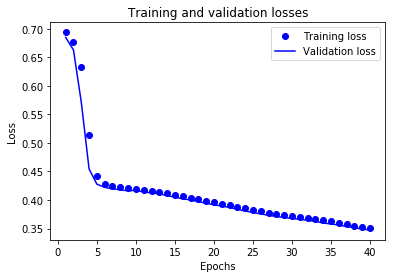

In [215]:
model_history = history.history

model_loss_values = model_history['loss']
validation_loss_values = model_history['val_loss']
epochs = range(1, len(model_history['acc']) + 1)

plt.plot(epochs, model_loss_values, 'bo', label='Training loss')
plt.plot(epochs, validation_loss_values, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

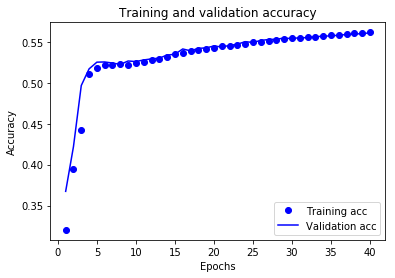

In [216]:
acc_values = model_history['acc']
validation_acc_values = model_history['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, validation_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [217]:
%%time

input_image = Input(shape=(shape_0, ))

encoded = Dense(32, activation='relu')(input_image)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(shape_0, activation='sigmoid')(decoded)

autoencoder = Model(input_image, decoded)
encoder = Model(input_image, encoded)

encoded_input = Input(shape=(encoding_dim, ))
decoder = Model(encoded_input, autoencoder.layers[-1](autoencoder.layers[-2](encoded_input)))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

full_dataset = numpy.concatenate((x_train, x_test))
autoencoder.fit(full_dataset,
                full_dataset,
                epochs=25, batch_size=128, verbose=False)

Wall time: 10.2 s


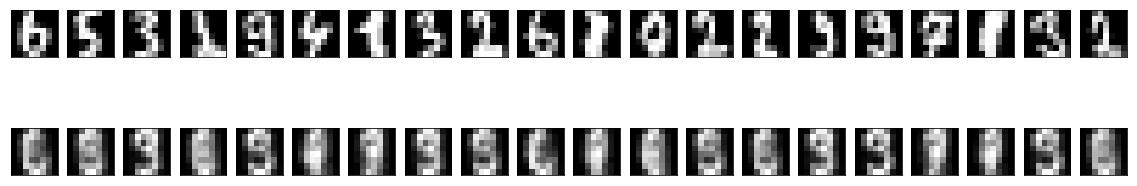

In [218]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 4))
n = 20
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(image_side_size, image_side_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(image_side_size, image_side_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Проблема - _не хватает данных_. Если, например, взять набор **MNIST** из **Keras**, то ровно на такой же архитектуре сети мы получим очень приличные результаты.